# Introduction

In this notebook, we'll implement simple RNNs, then explore how gradients flow through networks.

This notebook does not require a Colab GPU. If it's enabled, you can turn it off through Runtime -> Change runtime type. (This will make it more likely for you to get Colab GPU access later in the REAL_RNN_LSTM.ipynb problem.)

# Imports

Note: the ipympl installation will require you to restart the colab runtime.

In [212]:
! pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [213]:
import copy

# If you are not using colab you can delete these two lines
from google.colab import output
output.enable_custom_widget_manager()

import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets, Layout

In [214]:
%matplotlib ipympl

# 1.A: implementing a RNN layer (10 point)

Consider using Pytorch's [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear). You can implement this with either one Linear layer or two. If you use two, remember that you only need to include a bias term for one of the linear layers.

In [324]:
class RNNLayer(nn.Module):
  def __init__(self, input_size, hidden_size, nonlinearity=th.tanh):
    """
    Initialize a single RNN layer.

    Inputs:
    - input_size: Data input feature dimension
    - hidden_size: RNN hidden state size (also the output feature dimension)
    - nonlinearity: Nonlinearity applied to the rnn output
    """
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.nonlinearity = nonlinearity
    ##############################################################################
    # TODO: Initialize any parameters your class needs.                          #
    ##############################################################################
    self.linear = nn.Linear(input_size + hidden_size, hidden_size)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, x):
    """
    RNN forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep
    - last_h: hidden state from the last timestep (B, hidden_size)
    """
    h_list = []  # List to store the hidden states [h_1, ... h_T]
    ##############################################################################
    # TODO: Implement the RNN forward step                                       #
    # 1. Initialize h0 with zeros                                                #
    # 2. Roll out the RNN over the sequence, storing hidden states in h_list     #
    # 3. Return the appropriate outputs                                          #
    ##############################################################################
    h = th.zeros(x.size(0), self.hidden_size)  # Initialize h0 with zeros

    h_list = []  # List to store the hidden states [h_1, ... h_T]
    for t in range(x.size(1)):
        x_t = x[:, t, :]


        xh_t = th.cat((x_t, h), dim=1)


        h = self.linear(xh_t)


        h = self.nonlinearity(h)


        h_list.append(h)

    last_h = h

    # Get the input at time step t
    # Concatenate x[t] and h
    # Apply linear transformation
    # Apply nonlinearity
    # Store the hidden state at each timestep
    # Last hidden state
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    # h_list should now contain all hidden states, each of size (B, hidden_size)
    # We will store the hidden states so we can analyze their gradients later
    self.store_h_for_grad(h_list)
    all_h = th.stack(h_list, dim=1)
    return all_h, last_h

  def store_h_for_grad(self, h_list):
    """
    Store input list and allow gradient computation for all list elements
    """
    for h in h_list:
      h.retain_grad()
    self.h_list = h_list


### Test Cases

If your implementation is correct, you should expect to see errors of less than 1e-4.

In [325]:
rnn = RNNLayer(1, 1)
# Overwrite initial parameters with fixed values.
# Should give deterministic results even with different implementations.
rnn.load_state_dict({k: v * 0 + .1 for k, v in rnn.state_dict().items()})
data = th.ones((1, 1, 1))
expected_out = th.FloatTensor([[[0.1973753273487091]]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_out.shape
assert th.all(th.isclose(all_h, last_h))
print(f'Expected: {expected_out.item()}, got: {last_h.item()}, max error: {th.max(th.abs(expected_out - last_h)).item()}')

rnn = RNNLayer(2, 3, nonlinearity=lambda x: x)  # no nonlinearity

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 18, f'expected 18 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_all_h = th.FloatTensor([[[-0.1250, -0.1250, -0.1250],
         [-0.1075, -0.1075, -0.1075],
         [-0.1328, -0.1328, -0.1328],
         [-0.1452, -0.1452, -0.1452]],

        [[ 0.0600,  0.0600,  0.0600],
         [ 0.1520,  0.1520,  0.1520],
         [ 0.2344,  0.2344,  0.2344],
         [-0.0853, -0.0853, -0.0853]]])
expected_last_h = th.FloatTensor([[-0.1452, -0.1452, -0.1452],
        [-0.0853, -0.0853, -0.0853]])
all_h, last_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert last_h.shape == expected_last_h.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_last_h - last_h)).item()}')

Expected: 0.1973753273487091, got: 0.1973753273487091, max error: 0.0
Max error all_h: 4.999339580535889e-05
Max error last_h: 2.498924732208252e-05


# 1.B Implementing a RNN regression model. (15 point)


In [327]:
class RecurrentRegressionModel(nn.Module):
  def __init__(self, recurrent_net, output_dim=1):
    """
    Initialize a simple RNN regression model

    Inputs:
    - recurrent_net: an RNN or LSTM (single or multi layer)
    - output_dim: feature dimension of the output
    """
    super().__init__()
    self.recurrent_net = recurrent_net
    self.output_dim = output_dim
    ##############################################################################
    # TODO: Initialize any parameters you need                                   #
    # HINT: use recurrent_net.hidden_size to find the hidden state size          #
    ##############################################################################
    hidden_size = self.recurrent_net.hidden_size

    self.linear = nn.Linear(hidden_size, self.output_dim)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, x):
    """
    Forward pass

    Inputs:
    - x: input tensor (B, seq_len, input_size)

    Returns:
    - out: predictions of shape (B, seq_len, self.output_dim).
    - all_h: tensor of size (B, seq_len, hidden_size) containing hidden states
             produced for each timestep.
    """
    ##############################################################################
    # TODO: Implement the forward step.                                          #
    ##############################################################################
    all_h, _ = self.recurrent_net(x)
    out = self.linear(all_h)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return out, all_h


## Tests

In [328]:
rnn = RecurrentRegressionModel(RNNLayer(2, 3), 4)

num_params = sum(p.numel() for p in rnn.parameters())
assert num_params == 34, f'expected 34 parameters but found {num_params}'

rnn.load_state_dict({k: v * 0 - .1 for k, v in rnn.state_dict().items()})
data = th.FloatTensor([[[.1, .15], [.2, .25], [.3, .35], [.4, .45]], [[-.1, -1.5], [-.2, -2.5], [-.3, -3.5], [-.4, -.45]]])
expected_preds = th.FloatTensor([[[-0.0627, -0.0627, -0.0627, -0.0627],
         [-0.0678, -0.0678, -0.0678, -0.0678],
         [-0.0604, -0.0604, -0.0604, -0.0604],
         [-0.0567, -0.0567, -0.0567, -0.0567]],

        [[-0.1180, -0.1180, -0.1180, -0.1180],
         [-0.1453, -0.1453, -0.1453, -0.1453],
         [-0.1692, -0.1692, -0.1692, -0.1692],
         [-0.0748, -0.0748, -0.0748, -0.0748]]])
expected_all_h = th.FloatTensor([[[-0.1244, -0.1244, -0.1244],
         [-0.1073, -0.1073, -0.1073],
         [-0.1320, -0.1320, -0.1320],
         [-0.1444, -0.1444, -0.1444]],

        [[ 0.0599,  0.0599,  0.0599],
         [ 0.1509,  0.1509,  0.1509],
         [ 0.2305,  0.2305,  0.2305],
         [-0.0840, -0.0840, -0.0840]]])
preds, all_h = rnn(data)
assert all_h.shape == expected_all_h.shape
assert preds.shape == expected_preds.shape
print(f'Max error all_h: {th.max(th.abs(expected_all_h - all_h)).item()}')
print(f'Max error last_h: {th.max(th.abs(expected_preds - preds)).item()}')

Max error all_h: 4.699826240539551e-05
Max error last_h: 4.312396049499512e-05


# 1.C: Dataset and loss function (15 point)

## 1.C.i: Understanding the dataset (no implementation needed)

Inspect the code and plots below to visualize the dataset

In [329]:
def generate_batch(seq_len=10, batch_size=1):
  data = th.randn(size=(batch_size, seq_len, 1))
  sums = th.cumsum(data, dim=1)
  div = (th.arange(seq_len) + 1).unsqueeze(0).unsqueeze(2)
  target = sums / div
  return data, target

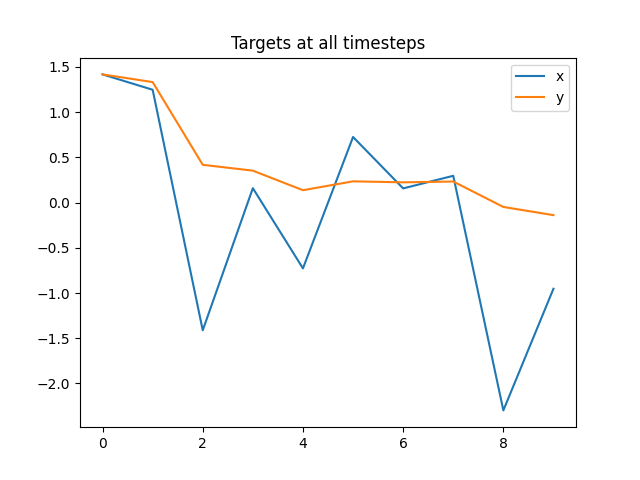

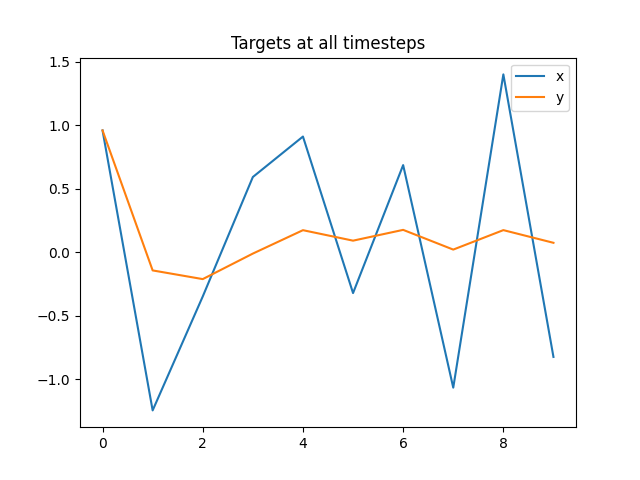

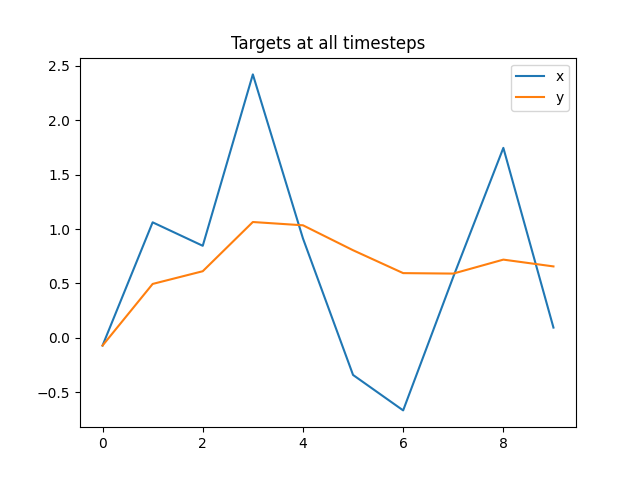

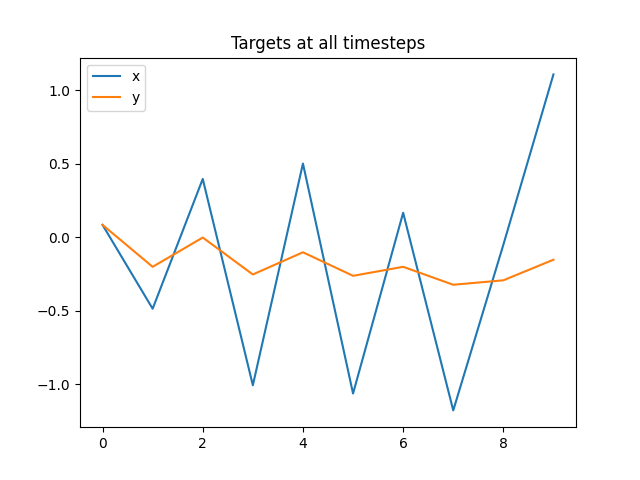

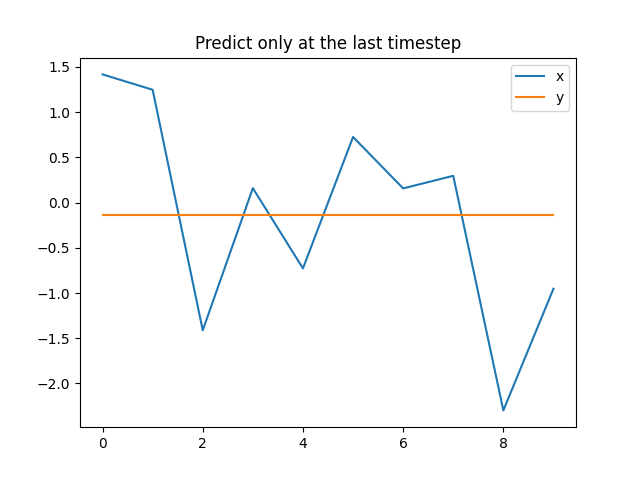

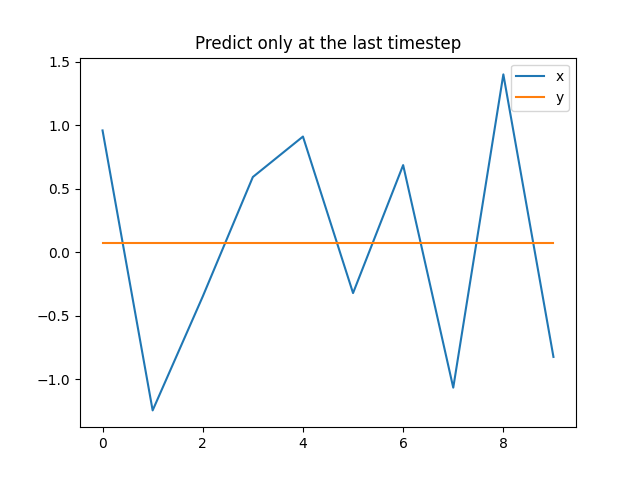

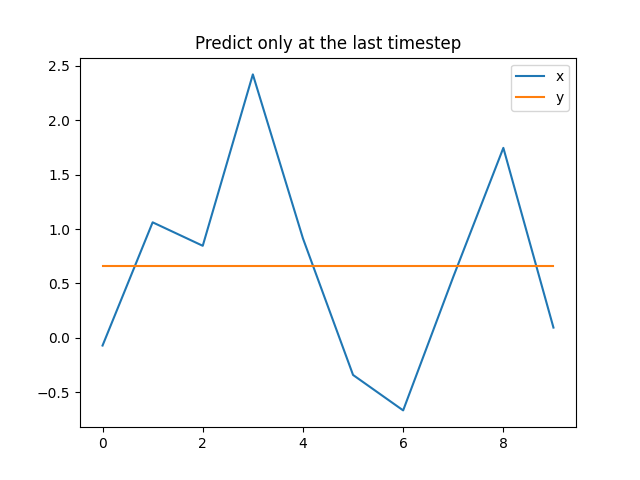

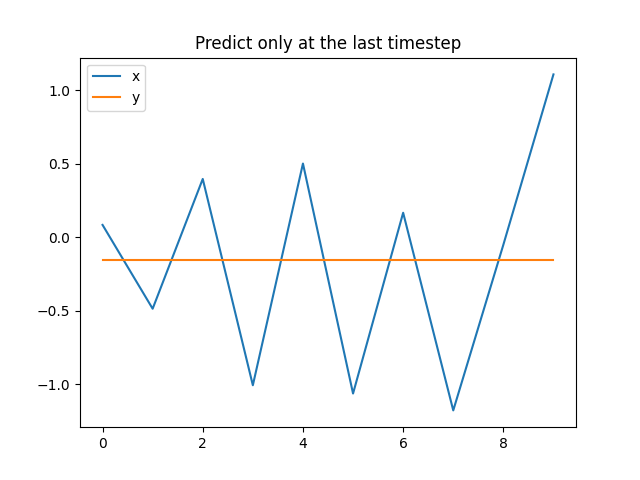

In [331]:
x, y = generate_batch(seq_len=10, batch_size=4)
for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(y[i, :, 0])
  ax1.legend(['x', 'y'])
  plt.title('Targets at all timesteps')
  plt.show()

for i in range(4):
  fig, ax1 = plt.subplots(1)
  ax1.plot(x[i, :, 0])
  ax1.plot(np.arange(10), [y[i, -1].item()] * 10)
  ax1.legend(['x', 'y'])
  plt.title('Predict only at the last timestep')
  plt.show()

## 1.C.ii Implement the loss function

In [336]:
def loss_fn(pred, y, last_timestep_only=False):
  """
  Inputs:
  - pred: model predictions of size (batch, seq_len, 1)
  - y: targets of size (batch, seq_len, 1)
  - last_timestep_only: boolean indicating whether to compute loss for all
    timesteps or only the lat

  Returns:
  - loss: scalar MSE loss between pred and true labels
  """
  ##############################################################################
  # TODO: implement the loss (HINT: look for pytorch's MSELoss function)       #
  ##############################################################################
  criterion = nn.MSELoss()

  if last_timestep_only:
      # Compute loss only for the last time step
      loss = criterion(pred[:, -1].unsqueeze(-1), y[:, -1].unsqueeze(-1))
  else:
      # Compute loss for all time steps
      loss = criterion(pred, y)

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################
  return loss

### Tests
You should see errors < 1e-4

In [337]:
pred = th.FloatTensor([[.1, .2, .3], [.4, .5, .6]])
y = th.FloatTensor([[-1.1, -1.2, -1.3], [-1.4, -1.5, -1.6]])
loss_all = loss_fn(pred, y, last_timestep_only=False)
loss_last = loss_fn(pred, y, last_timestep_only=True)
assert loss_all.shape == loss_last.shape == th.Size([])
print(f'Max error loss_all: {th.abs(loss_all - th.tensor(3.0067)).item()}')
print(f'Max error loss_last: {th.abs(loss_last - th.tensor(3.7)).item()}')

Max error loss_all: 3.314018249511719e-05
Max error loss_last: 2.384185791015625e-07


**粗體文字**# 1.D: Analyzing RNN Gradients (10 point)

You do not need to understand the details of the GradientVisualizer class in order to complete this problem.

In [340]:
def biggest_eig_magnitude(matrix):
  """
  Inputs: a square matrix
  Returns: the scalar magnitude of the largest eigenvalue
  """
  h, w = matrix.shape
  assert h == w, f'Matrix has shape {matrix.shape}, but eigenvalues can only be computed for square matrices'
  eigs = th.linalg.eigvals(matrix)
  eig_magnitude = eigs.abs()
  eigs_sorted = sorted([i.item() for i in eig_magnitude], reverse=True)
  first_eig_magnitude = eigs_sorted[0]
  return first_eig_magnitude

class GradientVisualizer:

  def __init__(self, rnn, last_timestep_only):
    """
    Inputs:
    - rnn: rnn module
    - last_timestep_only: boolean indicating whether to compute loss for all
      timesteps or only the lat

    Returns:
    - loss: scalar MSE loss between pred and true labels
    """

    self.rnn = rnn
    self.last_timestep_only = last_timestep_only
    self.model = RecurrentRegressionModel(rnn)
    self.original_weights = copy.deepcopy(rnn.state_dict())

    # Generate a single batch to be used repeatedly
    self.x, self.y = generate_batch(seq_len=10)
    print(f'Data point: x={np.round(self.x[0, :, 0].detach().cpu().numpy(), 2)}, y={np.round(self.y.squeeze().detach().cpu().numpy(), 2)}')

  def plot_visuals(self):
    """ Generate plots which will be updated in realtime."""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('RNN Outputs')
    ax1.set_xlabel('Unroll Timestep')
    ax1.set_ylabel('Hidden State Norm')
    ax1.set_ylim(-1, 5)
    plt_1 = ax1.plot(np.arange(1, 11), np.zeros(10) + 1)  # placeholder vals
    plt_1 = plt_1[0]

    ax2.set_title('Gradients')
    ax2.set_xlabel('Unroll Timestep')
    ax2.set_ylabel('RNN dLoss/d a_t Gradient Magitude')
    ax2.set_ylim( (10**-6,1e5) )
    ax2.set_yscale('log')
    # X-axis labels are reversed since the gradient flow is from later layers to earlier layers
    ax2.set_xticks(np.arange(10), np.arange(10, 0, -1))
    plt_2 = ax2.plot(np.arange(10), np.arange(10) + 1)  # placeholder vals
    plt_2 = plt_2[0]
    self.fig = fig
    self.plots = [plt_1, plt_2]
    return plt_1, plt_2, fig

  # Main update function for interactive plot
  def update_plots(self, weight_val=0, bias_val=0):
    # Scale the original RNN weights by a constant
    w_dict = copy.deepcopy(self.original_weights)
    ##############################################################################
    # TODO: Scale all W matrixes by weight_val, and all bias matrices by bias_val#
    # If you're using PyTorch nn.Linear layers, you don't need to modify the code#
    # provided, but if you're using custom layers, modify this block.            #
    ##############################################################################
    for k in w_dict.keys():
      if 'weight' in k:
        w_dict[k][:] *= weight_val
      elif 'bias' in k:
        w_dict[k][:] *= bias_val
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    self.rnn.load_state_dict(w_dict)

    # Don't compute for LSTMs, which don't have behavior dependent on a single eigenvalue
    if isinstance(self.rnn, RNNLayer):
      ##############################################################################
      # TODO: Set W = the weight which most affects exploding/vanishing gradients  #
      # Hint: Call module.weight or module.bias on the module you want to use      #
      # If you used a single Linear layer, slice a square matrix from it.          #
      ##############################################################################
      W = self.rnn.linear.weight
      W = th.matmul(W.t(), W)
      ##############################################################################
      #                               END OF YOUR CODE                             #
      ##############################################################################
      biggest_eig = biggest_eig_magnitude(W)
      print(f' Biggest eigenvalue magnitude: {biggest_eig:.3}')

    # Run model
    pred, h = self.model(self.x)
    loss = loss_fn(pred, self.y, self.last_timestep_only)
    n_steps = len(h[0])

    plt_1, plt_2 = self.plots

    # Plot the hidden state magnitude
    max_h = th.linalg.norm(h[0], dim=-1).detach().cpu().numpy()
    print('Max H', ' '.join([f'{num:.3}' for num in max_h]))
    plt_1.set_data(np.arange(1, n_steps + 1), np.array(max_h))
    # Compute the gradient for the loss wrt the stored hidden states
    # Gradients are plotted backward since we go from later layers to earlier
    grads = [th.linalg.norm(num).item() for num in th.autograd.grad(loss, self.rnn.h_list)][::-1]
    print('gradients d Loss/d h_t', ' '.join([f'{num:.3}' for num in grads]))
    # Add 1e-6 since it throws an error for gradients near 0
    plt_2.set_data(np.arange(n_steps), np.array(grads) + 1e-6)
    self.fig.canvas.draw_idle()

  def create_visualization(self):
    # Include sliders for relevant quantities
    self.plot_visuals()
    ip = interactive(self.update_plots,
                    weight_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="weight_scale", layout=Layout(width='100%')),
                    bias_val=widgets.FloatSlider(value=0, min=-5, max=5, step=.05, description="bias_scale", layout=Layout(width='100%')),
                    )
    return ip

Adjust the sliders rescale the weight and bias parameters in the RNN. Observe the effect on exploding and vanishing gradients.

Parameters to try varying:
*   nonlinearity
*   last_target_only



Data point: x=[ 1.18 -0.96 -0.69  0.2   1.43 -0.88  1.54  2.52 -0.25 -1.17], y=[ 1.18  0.11 -0.16 -0.07  0.23  0.05  0.26  0.54  0.45  0.29]


interactive(children=(FloatSlider(value=0.0, description='weight_scale', layout=Layout(width='100%'), max=5.0,…

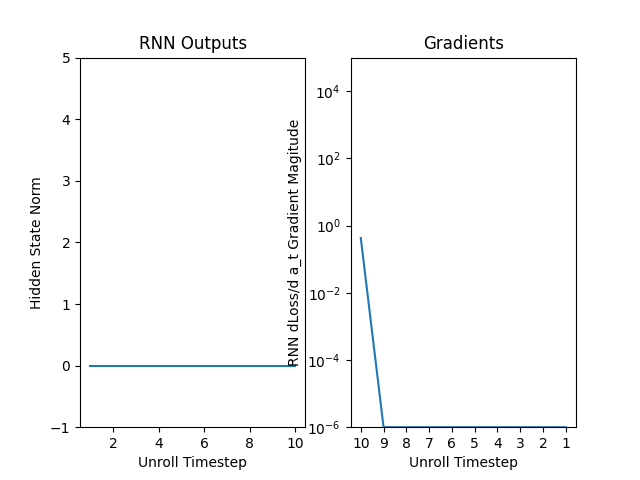

In [342]:
hidden_size = 16
nonlinearity = lambda x: x  # options include lambda x: x (no nonlinearity), nn.functional.relu, and th.tanh
last_target_only = True
rnn = RNNLayer(1, hidden_size, nonlinearity=nonlinearity)
gv = GradientVisualizer(rnn, last_target_only)
gv.create_visualization()

# If for some reason the slider doesn't work for you, try calling gv.update_plots
# with various values for weight and bias

# 2.a RNN for Last Name Classification (25 point)

Welcome to this assignment where you will train a neural network to predict the probable language of origin for a given last name / family name in Latin alphabets.

Throughout this task, you will gain expertise in the following areas:

- Preprocessing raw text data for suitable input into an RNN and (Optionally) LSTM.
- Utilizing PyTorch to train your recurrent neural network models.
- Evaluating your model's performance and making predictions on unseen data.

LSTM is out-of-scope this semester and will not be covered in the exams.


## Download Data

In [ ]:
import os

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

--2023-11-23 13:49:09--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.71, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2023-11-23 13:49:09 (36.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/

## Library imports

Before starting, make sure you have all these libraries.

In [107]:
root_folder = ""
import os
import sys
import inspect
sys.path.append(root_folder)
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implement the Neural Network

The main objective of this task is to predict the probability of a given class given a last name, represented as

$$ \Pr ( y | x_1, x_2, x_3, ..., x_i),$$

where $y$ is the category label and each $x_i$ is a character in the last name. Building a basic character-level NLP model has the advantage of understanding how the preprocessing works at a granular level. The character-level network reads words as a sequence of characters, producing a prediction and "hidden state" at each step by feeding its previous hidden state into the next step. The final prediction corresponds to the class to which the word belongs.

All models in PyTorch inherit from the nn.Module subclass. In this assignment, you will **implement a custom model named `RecurrentClassifier`** that runs either [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and define its forward function. The implementation of LSTMs is *optional*.

The forward pass of the model can be visualized with the following diagram:

```
[Embedding] -> [RNN Stack] -> [Extract Last Position] -> [Classifier]
```

- **Embedding:** This component maps each input word (integer) to a vector of real numbers.
    - Input: `[batch_size, seq_len]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **RNN Stack:** This component consists of one or more RNN layers, which process the input sequence of vectors from the Embedding component.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, seq_len, rnn_size]`
- **Extract Last Position:** The RNN Stack component returns a sequence of vectors for each input example. However, for classification purposes, we only need a single vector that captures the full information of the input example. Since the RNN is left-to-right by default, the output state vector at the last position contains the full information of the input example. Therefore, for the $i$-th input example, we extract the output state vector at the last *non-pad* position, which is indicated by `last_pos[i]`.
    - Input: `[batch_size, seq_len, rnn_size]`
    - Output: `[batch_size, rnn_size]`
- **Classifier:** This component is a fully-connected layer that maps the output vectors extracted in the previous step to logits (scores before softmax), which can be used to make predictions about the language of origin for each input example.
    - Input: `[batch_size, rnn_size]`
    - Output: `[batch_size, n_categories]`


These documents would be helpful in this part:

- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
- https://pytorch.org/docs/stable/generated/torch.gather.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [109]:
class RecurrentClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        rnn_size: int,
        n_categories: int,
        num_layers: int = 1,
        dropout: float = 0.0,
        model_type: str = 'lstm'
    ):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type
        self.vocab_size = vocab_size
        ########################################################################
        # TODO: Create an embedding layer of shape [vocab_size, rnn_size]
        #
        # Hint: Use nn.Embedding
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        # It will map each word into a vector of shape [rnn_size]
        ########################################################################

        self.embedding = nn.Embedding(vocab_size, rnn_size)


        ########################################################################

        ########################################################################
        # TODO: Create a RNN stack with `num_layers` layers with tanh
        #       nonlinearity. Between each layers, there is a dropout of
        #       `dropout`. Implement it with a *single* call to `torch.nn` APIs
        #
        # Hint: See documentations at
        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # Set the arguments to call `nn.RNN` such that:
        # - The shape of the input is [batch_size, seq_len, rnn_size]
        # - The shape of the output should be [batch_size, seq_len, rnn_size]
        # Make sure that the dimension ordering is correct. One of the argument
        #   in the constructor of `nn.RNN` (or `nn.LSTM`) is helpful here
        #
        # Optional: Implement one LSTM layer when `model_type` is `lstm`
        ########################################################################
        if model_type == 'lstm':

            self.lstm = nn.LSTM(rnn_size, rnn_size, num_layers, dropout=dropout, batch_first=True)
        elif model_type == 'rnn':

            self.rnn = nn.RNN(rnn_size, rnn_size, num_layers, nonlinearity='tanh', batch_first=True, dropout=dropout)
        ########################################################################

        ########################################################################
        # TODO: Implement one dropout layer and the fully-connected classifier
        #       layer
        #
        # Hint: We add a dropout layer because neither nn.RNN nor nn.LSTM
        #   implements dropout after the last layer in the stack.
        # Since the input to the classifier is the output of the last position
        #   of the RNN's final layer, it has a shape of [batch_size, rnn_size].
        # The expected output should be logits, which correspond to scores
        #   before applying softmax, and should have a shape of
        #   [batch_size, n_categories].
        ########################################################################

        self.drop = nn.Dropout(dropout)

        self.output = nn.Linear(rnn_size, n_categories)
        ########################################################################

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        """
        x: integer tensor of shape [batch_size, seq_len]
        last_pos: integer tensor of shape [batch_size]

        The input tensor `x` is composed of a batch of sequences, where each
        sequence contains indices corresponding to characters. As sequences
        within the same batch may have different lengths, shorter sequences are
        padded on the right side to match the maximum sequence length of the
        batch, which is represented by `seq_len`.

        Additionally, the `last_pos` tensor records the position of the last
        character in each sequence. For instance, the first sequence in the
        batch can be represented as `[x[0, 0], x[0, 1], ..., x[0, last_pos[0]]`.
        `last_pos` is useful when extracting the output state associated with
        each sequence from the RNNs.
        """
        embeds = self.embedding(x)

        if self.model_type == 'lstm':
            rnn_out, _ = self.lstm(embeds)
        else:
            rnn_out, _ = self.rnn(embeds)

        ########################################################################
        # TODO: Retrieve the output state associated with each sequence
        #
        # Hints:
        # - The output state of all positions is returned by the RNN stack,
        #   but we only need the state in the last position for classification
        #   - The shape of `rnn_out` is [batch_size, seq_len, rnn_size]
        #   - The expected shape of `out` is [batch_size, rnn_size]
        # - For the i-th sequence, we have out[i] == rnn_out[i, last_pos[i]]
        # - Try to condense your code into a single line, without using any
        #   loops. However, if you find it too challenging to do so, you may use
        #   a single layer of for-loop.
        ########################################################################

        out = rnn_out.gather(1, last_pos.view(-1, 1, 1).expand(-1, -1, self.rnn_size)).squeeze(1)

        ########################################################################
        out = self.drop(out)
        logits = self.output(out)
        return logits



After completing your implementation, ensure that it passes the following tests. If your implementation fails some tests, but you believe that your implementation is correct, please post the error message along with a brief description on Ed. Please refrain from posting your actual code on Ed.

In [110]:
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = RecurrentClassifier(11, 13, 17, 2, 0.1, 'rnn')

In [111]:
assert list(model.state_dict().keys()) == ['embedding.weight',
 'rnn.weight_ih_l0',
 'rnn.weight_hh_l0',
 'rnn.bias_ih_l0',
 'rnn.bias_hh_l0',
 'rnn.weight_ih_l1',
 'rnn.weight_hh_l1',
 'rnn.bias_ih_l1',
 'rnn.bias_hh_l1',
 'output.weight',
 'output.bias']
assert model.embedding.weight.shape == torch.Size([11, 13])
assert (
    model.rnn.weight_ih_l0.shape
    == model.rnn.weight_hh_l0.shape
    == model.rnn.weight_ih_l1.shape
    == model.rnn.weight_hh_l1.shape
    == torch.Size([13, 13])
)
assert (
    model.rnn.bias_ih_l0.shape
    == model.rnn.bias_hh_l0.shape
    == model.rnn.bias_ih_l1.shape
    == model.rnn.bias_hh_l1.shape
    == torch.Size([13])
)
assert model.output.weight.shape == torch.Size([17, 13])
assert model.output.bias.shape == torch.Size([17])

In [112]:
x = torch.arange(20).view(5, 4) % 11
last_pos = torch.tensor([2, 3, 1, 2, 3])
seed = 1025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
logits = model(x, last_pos)
assert logits.shape == torch.Size([5, 17])
assert torch.allclose(
    logits.view(-1)[40:45],
    torch.tensor(
        [
            -0.27393126487731934,
            0.28421181440353394,
            0.2342953234910965,
            0.23580458760261536,
            0.06812290847301483
        ],
        dtype=torch.float
    )
)

model.zero_grad()
logits.sum().backward()
assert torch.allclose(
    model.rnn.weight_hh_l0.grad.view(-1)[40:45],
    torch.tensor(
        [
            -0.9424352645874023,
            -0.488606333732605,
            0.6905138492584229,
            -0.0017577260732650757,
            1.1024625301361084
        ],
        dtype=torch.float
    )
)

## Preprocess the dataset

The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}.




In [176]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

assert findFiles('data/names/*.txt'), "Data not found!"

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("The normalized form of", 'Ślusàrski', "is", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

The normalized form of Ślusàrski is Slusarski


In [174]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [175]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

**Implement the function to encode a letter to an integer:**

In [115]:
def letterToIndex(letter):
    ############################################################################
    # TODO: implement the function to map a letter (a character) into its index
    #       in `all_letters`
    #
    # e.g. letterToIndex("a") == 0
    # Don't worry about efficiency here
    ############################################################################
    all_letters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
    return all_letters.index(letter)
    ############################################################################

assert letterToIndex("a") == 0
assert letterToIndex("'") == 56


In [116]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character
vocab_size = 58 # number of characters used in total

In [117]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}.

  We want to translate our dictionary into a dataset that has one entry per name.
  Each datapoint is a 3-tuple consisting of:
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19, dtype=np.int64) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [118]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [119]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [120]:
len(train_data)

16059

In [121]:
train_data[0]

(array([35,  8, 21,  0,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 11,
 5)

In [122]:
len(test_data)

4015

In [123]:
test_data[0]

(array([32,  0,  6,  4, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57, 57]),
 11,
 4)

# 2.b Train the model (15 point for code, 10 point for writing)

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

In [124]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset. See the next cell for
    when and how it's used.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories

In [125]:
build_batch(train_data, [1, 2, 3])

(array([[29, 21, 14, 17,  0, 10, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [35,  4, 11,  4,  7, 14, 21, 18, 10, 24, 57, 57, 57, 57, 57, 57,
         57, 57, 57],
        [27,  4, 11,  8, 13,  3,  4, 17, 57, 57, 57, 57, 57, 57, 57, 57,
         57, 57, 57]]),
 array([ 6, 11, 11]),
 array([5, 9, 7]))

**Adjust the hyperparameters listed below** to train an RNN with a minimum evaluation accuracy of 80% after 20 epochs. Your score will be graded on a linear scale, ranging from 0 to the maximum score, as the validation accuracy achieved after the last epoch changes from 70% to 80% (i.e., you get 0 if the accuracy is less than 70%, and get the full score if the accuracy is greater than 80% for this autograding item).

In [151]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())

############################################################################
# TODO: Tune these hyperparameters for a better performance
############################################################################
hidden_size = 140
num_layers = 2
dropout = 0.3
optimizer_class = optim.Adam
lr = 1e-3
batch_size = 140
############################################################################

# Do not change the number of epochs
epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [152]:
# Optional
lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [153]:
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [154]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

In [155]:
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 109  Loss: 1.0159351706504822: 100%|██████████| 115/115 [00:00<00:00, 287.75it/s]


Epoch: 0  Train Accuracy: 62.59418394669656
Epoch: 0  Eval Accuracy: 70.66002490660026


Epoch: 1  Iteration: 109  Loss: 0.8703699946403504: 100%|██████████| 115/115 [00:00<00:00, 304.39it/s]


Epoch: 1  Train Accuracy: 73.52886232019429
Epoch: 1  Eval Accuracy: 74.09713574097135


Epoch: 2  Iteration: 109  Loss: 0.7657805025577545: 100%|██████████| 115/115 [00:00<00:00, 240.39it/s]


Epoch: 2  Train Accuracy: 76.94750607136184
Epoch: 2  Eval Accuracy: 77.06102117061022


Epoch: 3  Iteration: 109  Loss: 0.7192092001438141: 100%|██████████| 115/115 [00:00<00:00, 257.22it/s]


Epoch: 3  Train Accuracy: 79.11451522510743
Epoch: 3  Eval Accuracy: 78.35616438356165


Epoch: 4  Iteration: 109  Loss: 0.7127525269985199: 100%|██████████| 115/115 [00:00<00:00, 285.02it/s]


Epoch: 4  Train Accuracy: 80.135749423999
Epoch: 4  Eval Accuracy: 77.85803237858032


Epoch: 5  Iteration: 109  Loss: 0.669077867269516: 100%|██████████| 115/115 [00:00<00:00, 270.30it/s]


Epoch: 5  Train Accuracy: 80.99508064013948
Epoch: 5  Eval Accuracy: 79.50186799501869


Epoch: 6  Iteration: 109  Loss: 0.5409548878669739: 100%|██████████| 115/115 [00:00<00:00, 263.61it/s]


Epoch: 6  Train Accuracy: 82.57674824086182
Epoch: 6  Eval Accuracy: 80.62266500622664


Epoch: 7  Iteration: 109  Loss: 0.5364702045917511: 100%|██████████| 115/115 [00:00<00:00, 259.84it/s]


Epoch: 7  Train Accuracy: 83.35512796562675
Epoch: 7  Eval Accuracy: 80.77210460772105


Epoch: 8  Iteration: 109  Loss: 0.5615781426429749: 100%|██████████| 115/115 [00:00<00:00, 247.38it/s]


Epoch: 8  Train Accuracy: 83.72875023351392
Epoch: 8  Eval Accuracy: 79.97509339975093


Epoch: 9  Iteration: 109  Loss: 0.5241247415542603: 100%|██████████| 115/115 [00:00<00:00, 297.14it/s]


Epoch: 9  Train Accuracy: 84.38881624011458
Epoch: 9  Eval Accuracy: 81.0211706102117


Epoch: 10  Iteration: 109  Loss: 0.5255118101835251: 100%|██████████| 115/115 [00:00<00:00, 339.25it/s]


Epoch: 10  Train Accuracy: 85.11737966249456
Epoch: 10  Eval Accuracy: 81.46948941469489


Epoch: 11  Iteration: 109  Loss: 0.5157485932111741: 100%|██████████| 115/115 [00:00<00:00, 343.37it/s]


Epoch: 11  Train Accuracy: 85.56572638395915
Epoch: 11  Eval Accuracy: 80.74719800747198


Epoch: 12  Iteration: 109  Loss: 0.4130167841911316: 100%|██████████| 115/115 [00:00<00:00, 341.11it/s]


Epoch: 12  Train Accuracy: 86.01407310542375
Epoch: 12  Eval Accuracy: 81.81818181818183


Epoch: 13  Iteration: 109  Loss: 0.433080330491066: 100%|██████████| 115/115 [00:00<00:00, 348.82it/s]


Epoch: 13  Train Accuracy: 86.49355501587894
Epoch: 13  Eval Accuracy: 81.22042341220424


Epoch: 14  Iteration: 109  Loss: 0.40478011667728425: 100%|██████████| 115/115 [00:00<00:00, 346.65it/s]


Epoch: 14  Train Accuracy: 86.7364094900056
Epoch: 14  Eval Accuracy: 81.69364881693649


Epoch: 15  Iteration: 109  Loss: 0.42932620346546174: 100%|██████████| 115/115 [00:00<00:00, 346.88it/s]


Epoch: 15  Train Accuracy: 87.07266953110405
Epoch: 15  Eval Accuracy: 81.22042341220424


Epoch: 16  Iteration: 109  Loss: 0.4124287605285645: 100%|██████████| 115/115 [00:00<00:00, 340.85it/s]


Epoch: 16  Train Accuracy: 87.5334703281649
Epoch: 16  Eval Accuracy: 81.3200498132005


Epoch: 17  Iteration: 109  Loss: 0.42577789127826693: 100%|██████████| 115/115 [00:00<00:00, 340.43it/s]


Epoch: 17  Train Accuracy: 88.29939597733359
Epoch: 17  Eval Accuracy: 80.94645080946451


Epoch: 18  Iteration: 109  Loss: 0.3664062172174454: 100%|██████████| 115/115 [00:00<00:00, 353.65it/s]


Epoch: 18  Train Accuracy: 88.21844448595803
Epoch: 18  Eval Accuracy: 82.11706102117061


Epoch: 19  Iteration: 109  Loss: 0.3838293433189392: 100%|██████████| 115/115 [00:00<00:00, 348.22it/s]


Epoch: 19  Train Accuracy: 88.52356933806588
Epoch: 19  Eval Accuracy: 81.56911581569116


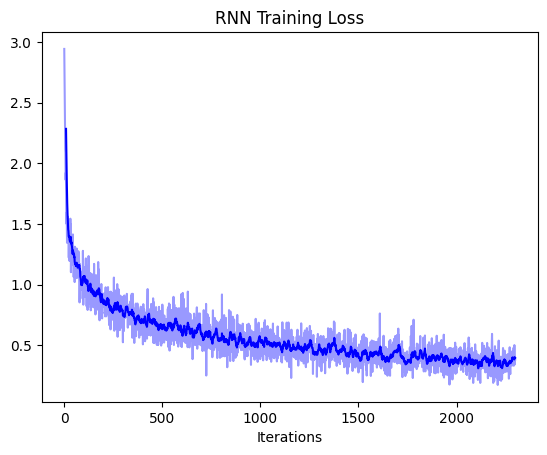

In [156]:
n_steps = len(rnn_log["history"]["train_losses"])
plt.plot(range(n_steps), rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, n_steps), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

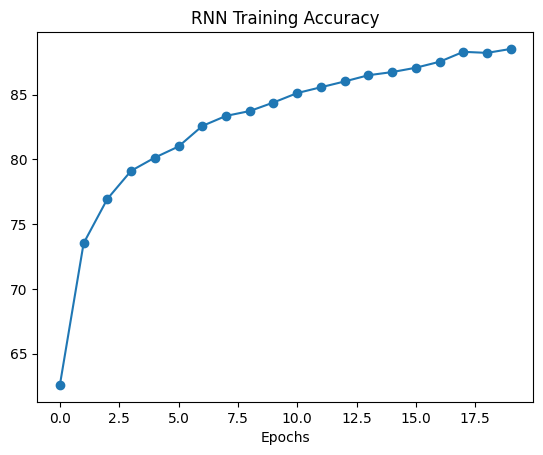

In [157]:
plt.plot(rnn_log["history"]["train_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Training Accuracy")
plt.show()

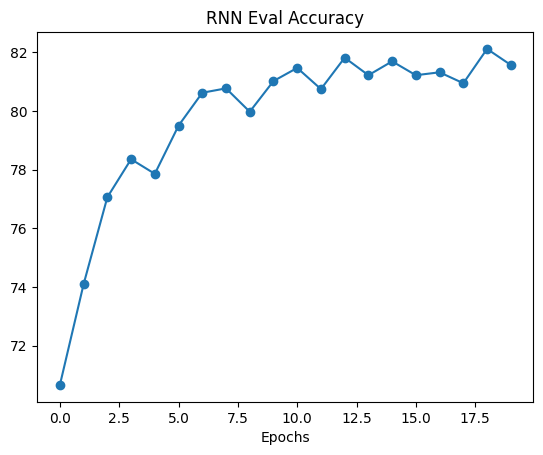

In [158]:
plt.plot(rnn_log["history"]["eval_accuracies"], marker='o')
plt.xlabel("Epochs")
plt.title("RNN Eval Accuracy")
plt.show()

In [159]:
#Optional
train(lstm_model, lstm_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 109  Loss: 1.1572197198867797: 100%|██████████| 115/115 [00:01<00:00, 93.24it/s]


Epoch: 0  Train Accuracy: 57.189115137928894
Epoch: 0  Eval Accuracy: 67.49688667496886


Epoch: 1  Iteration: 109  Loss: 0.8886284172534943: 100%|██████████| 115/115 [00:01<00:00, 103.50it/s]


Epoch: 1  Train Accuracy: 72.82520704900679
Epoch: 1  Eval Accuracy: 74.42092154420922


Epoch: 2  Iteration: 109  Loss: 0.731841504573822: 100%|██████████| 115/115 [00:01<00:00, 109.91it/s]


Epoch: 2  Train Accuracy: 77.57643688897191
Epoch: 2  Eval Accuracy: 78.80448318804483


Epoch: 3  Iteration: 109  Loss: 0.6663807153701782: 100%|██████████| 115/115 [00:01<00:00, 111.21it/s]


Epoch: 3  Train Accuracy: 80.15443053739337
Epoch: 3  Eval Accuracy: 79.65130759651308


Epoch: 4  Iteration: 109  Loss: 0.6176763474941254: 100%|██████████| 115/115 [00:01<00:00, 111.14it/s]


Epoch: 4  Train Accuracy: 82.05990410361791
Epoch: 4  Eval Accuracy: 80.34869240348692


Epoch: 5  Iteration: 109  Loss: 0.5982686161994935: 100%|██████████| 115/115 [00:01<00:00, 111.42it/s]


Epoch: 5  Train Accuracy: 83.32399277663616
Epoch: 5  Eval Accuracy: 80.72229140722291


Epoch: 6  Iteration: 109  Loss: 0.4841777592897415: 100%|██████████| 115/115 [00:01<00:00, 109.77it/s]


Epoch: 6  Train Accuracy: 84.19577806837287
Epoch: 6  Eval Accuracy: 82.09215442092155


Epoch: 7  Iteration: 109  Loss: 0.4890845715999603: 100%|██████████| 115/115 [00:01<00:00, 110.05it/s]


Epoch: 7  Train Accuracy: 85.50968304377608
Epoch: 7  Eval Accuracy: 81.91780821917808


Epoch: 8  Iteration: 109  Loss: 0.46552803814411164: 100%|██████████| 115/115 [00:01<00:00, 110.87it/s]


Epoch: 8  Train Accuracy: 86.40014944890716
Epoch: 8  Eval Accuracy: 81.84308841843088


Epoch: 9  Iteration: 109  Loss: 0.43341213166713716: 100%|██████████| 115/115 [00:01<00:00, 102.30it/s]


Epoch: 9  Train Accuracy: 86.84226913257363
Epoch: 9  Eval Accuracy: 81.71855541718556


Epoch: 10  Iteration: 109  Loss: 0.41070201992988586: 100%|██████████| 115/115 [00:01<00:00, 97.23it/s]


Epoch: 10  Train Accuracy: 87.70782738651224
Epoch: 10  Eval Accuracy: 83.16313823163138


Epoch: 11  Iteration: 109  Loss: 0.41195859014987946: 100%|██████████| 115/115 [00:01<00:00, 98.90it/s]


Epoch: 11  Train Accuracy: 88.49243414907528
Epoch: 11  Eval Accuracy: 82.81444582814446


Epoch: 12  Iteration: 109  Loss: 0.3364520758390427: 100%|██████████| 115/115 [00:01<00:00, 107.46it/s]


Epoch: 12  Train Accuracy: 88.82869419017374
Epoch: 12  Eval Accuracy: 82.16687422166873


Epoch: 13  Iteration: 109  Loss: 0.3230006605386734: 100%|██████████| 115/115 [00:01<00:00, 111.27it/s]


Epoch: 13  Train Accuracy: 89.60084687714055
Epoch: 13  Eval Accuracy: 82.83935242839352


Epoch: 14  Iteration: 109  Loss: 0.2901069223880768: 100%|██████████| 115/115 [00:01<00:00, 108.63it/s]


Epoch: 14  Train Accuracy: 90.4539510554829
Epoch: 14  Eval Accuracy: 82.88916562889166


Epoch: 15  Iteration: 109  Loss: 0.29309178739786146: 100%|██████████| 115/115 [00:01<00:00, 110.23it/s]


Epoch: 15  Train Accuracy: 90.98947630612118
Epoch: 15  Eval Accuracy: 83.26276463262765


Epoch: 16  Iteration: 109  Loss: 0.2962533891201019: 100%|██████████| 115/115 [00:01<00:00, 110.20it/s]


Epoch: 16  Train Accuracy: 91.28214708263279
Epoch: 16  Eval Accuracy: 82.86425902864259


Epoch: 17  Iteration: 109  Loss: 0.29475185126066206: 100%|██████████| 115/115 [00:01<00:00, 110.03it/s]


Epoch: 17  Train Accuracy: 91.68690453951055
Epoch: 17  Eval Accuracy: 83.36239103362391


Epoch: 18  Iteration: 109  Loss: 0.25518210232257843: 100%|██████████| 115/115 [00:01<00:00, 109.80it/s]


Epoch: 18  Train Accuracy: 92.20997571455258
Epoch: 18  Eval Accuracy: 83.28767123287672


Epoch: 19  Iteration: 109  Loss: 0.22950096875429155: 100%|██████████| 115/115 [00:01<00:00, 110.03it/s]


Epoch: 19  Train Accuracy: 92.44660315088112
Epoch: 19  Eval Accuracy: 82.78953922789539


{'history': {'train_losses': [2.9413633346557617,
   2.896441698074341,
   2.8545713424682617,
   2.8162918090820312,
   2.7634289264678955,
   2.674974203109741,
   2.6305856704711914,
   2.4690511226654053,
   2.417818784713745,
   2.330895185470581,
   2.0227127075195312,
   1.7869747877120972,
   1.8496732711791992,
   1.7673964500427246,
   1.6574890613555908,
   1.8019192218780518,
   1.8624283075332642,
   1.9319499731063843,
   2.007293701171875,
   1.730018138885498,
   1.6916874647140503,
   1.7794983386993408,
   1.7009525299072266,
   1.6317275762557983,
   1.752682089805603,
   1.695054531097412,
   1.7142314910888672,
   1.5896660089492798,
   1.7752617597579956,
   1.6432344913482666,
   1.6745476722717285,
   1.8111095428466797,
   1.7375634908676147,
   1.7112929821014404,
   1.3690526485443115,
   1.5443227291107178,
   1.4943301677703857,
   1.5341747999191284,
   1.501455545425415,
   1.5668015480041504,
   1.385494589805603,
   1.5023521184921265,
   1.465698242187

## Use Your RNN: Try Your Own Name

Attempt to use the code cells below to **predict the origin of your own last name**.

Please refrain from entering the last names of your classmates, as the names you enter will be logged for anti-plagiarism purposes.

In [160]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the
    predicted class.
    '''
    # change this if your last name is longer than 19 characters
    token = np.ones(19, dtype=np.int64) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    print(token)
    logits = model(
        torch.tensor(token, dtype=torch.long)[None, :],
        torch.tensor([n - 1], dtype=torch.long)
    )
    return logits.argmax(dim=-1).item()

In [211]:
model = rnn_model
model.eval()
model.cpu()
############################################################################
# TODO: Enter your last name
############################################################################
name = "Loki"
############################################################################
rnn_log["last_name"] = name
rnn_log["source_init"] = inspect.getsource(RecurrentClassifier.__init__)
rnn_log["source_forward"] = inspect.getsource(RecurrentClassifier.forward)
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Loki
[37 14 10  8 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Russian


### Question

Although the neural network you have trained is intended to predict the language of origin for a given last name, it could potentially be misused. **In what ways do you think this could be problematic in real-world applications?** Include your answer in this block.


Firstly, privacy is a paramount concern. Individuals may not be comfortable with the idea of a tool deducing their ethnic or national origin based on their surname without their explicit consent.

Secondly, there’s a risk of discrimination. The tool could potentially be misused to prejudge individuals based on their predicted ethnic or national origin in various contexts, such as employment or housing, which is unequivocally unacceptable.

Thirdly, the tool’s predictions may not always be accurate. If these predictions were to be used in critical decision-making processes, it could lead to unjust outcomes.

Furthermore, over-reliance on such a tool could inadvertently reinforce stereotypes and biases. It’s crucial to remember that a person’s surname, while potentially indicative of their heritage, does not define their identity or capabilities.

Lastly, there are significant ethical considerations surrounding the use of AI and machine learning models to make predictions about individuals based on personal characteristics like their surnames. These considerations encompass issues of fairness, accountability, and transparency.
